In [15]:
import numpy as np
import pandas as pd

import pathlib

import pickle

import os
import sys

import math
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

import torch


In [8]:
sys.path.insert(0, "../src")

In [9]:
from custom_distance import KL

# SHAC Results

In [2]:
path_results = ["../output/step103_runExp_SingleLabel_SHAC/exp_SingleHead_SHAC_05_1/"]

In [10]:
df_ls = []

loss = torch.nn.NLLLoss()
for path_i in pathlib.Path(path_results[0]).glob("setting*"):

    with open(pathlib.Path(path_i, "full_settings.pkl"), "br") as f:
        full_setting_i = pickle.load(f)

    for rand_i in path_i.glob("RandomRun_*"):


        num_i = os.path.basename(rand_i).split("_")[1]
        y_pred = pd.read_csv(pathlib.Path(rand_i, "y_pred.csv"))
        y_prob = pd.read_csv(pathlib.Path(rand_i, "y_prob.csv"))
        y_test = pd.read_csv(pathlib.Path(rand_i, "y_test.csv"))

        auprc = metrics.average_precision_score(y_true=y_test, y_score=y_prob.iloc[:,1])
        f1_at_05 = metrics.f1_score(y_true=y_test.values, y_pred=y_prob.iloc[:,1]>0.5)
        _loss = loss(
            torch.log(torch.tensor(y_prob.values)),
            torch.LongTensor(y_test.values).squeeze(1),
        ).item()

        _df = pd.DataFrame.from_dict(full_setting_i['mix_param_dict'], orient='index').T

        _df['distance_KL_Train_Test'] = _df.apply(lambda x: KL([1-x['p_pos_train_z0'], x['p_pos_train_z0'], 1-x['p_pos_train_z1'], x['p_pos_train_z1']], 
                                                               [1-x['p_pos_test_z0'], x['p_pos_test_z0'], 1-x['p_pos_test_z1'], x['p_pos_test_z1']],),
                                                  axis=1)
        _df['auprc'] = auprc
        _df['f1_at_05'] = f1_at_05
        _df['run'] = num_i
        _df['test_loss'] = _loss

        df_ls.append(_df)

In [11]:
df = pd.concat(df_ls).reset_index(drop=True)

In [12]:
df

,p_pos_train_z0,p_pos_train_z1,p_pos_train,p_pos_test,p_mix_z0,p_mix_z1,alpha_train,alpha_test,p_pos_test_z0,p_pos_test_z1,C_y,C_z,distance_KL_Train_Test,auprc,f1_at_05,run,test_loss
0,0.5,0.2,0.35,0.35,0.5,0.5,0.4,2.2,0.218750,0.481250,0.35,0.5,0.361134,0.579267,0.500000,1,0.574758
1,0.5,0.2,0.35,0.35,0.5,0.5,0.4,2.2,0.218750,0.481250,0.35,0.5,0.361134,0.628039,0.415584,2,0.551650
2,0.5,0.2,0.35,0.35,0.5,0.5,0.4,2.2,0.218750,0.481250,0.35,0.5,0.361134,0.548778,0.187500,3,0.570017
3,0.5,0.2,0.35,0.35,0.5,0.5,0.4,2.2,0.218750,0.481250,0.35,0.5,0.361134,0.627224,0.564706,4,0.534573
4,0.5,0.2,0.35,0.35,0.5,0.5,0.4,2.2,0.218750,0.481250,0.35,0.5,0.361134,0.512160,0.235294,0,0.613901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.5,0.2,0.41,0.41,0.7,0.3,0.4,2.3,0.294964,0.678417,0.41,0.3,0.576853,0.855179,0.743363,1,0.488237
996,0.5,0.2,0.41,0.41,0.7,0.3,0.4,2.3,0.294964,0.678417,0.41,0.3,0.576853,0.699005,0.625000,2,0.576436
997,0.5,0.2,0.41,0.41,0.7,0.3,0.4,2.3,0.294964,0.678417,0.41,0.3,0.576853,0.706967,0.551020,3,0.592747
998,0.5,0.2,0.41,0.41,0.7,0.3,0.4,2.3,0.294964,0.678417,0.41,0.3,0.576853,0.813831,0.715447,4,0.503506


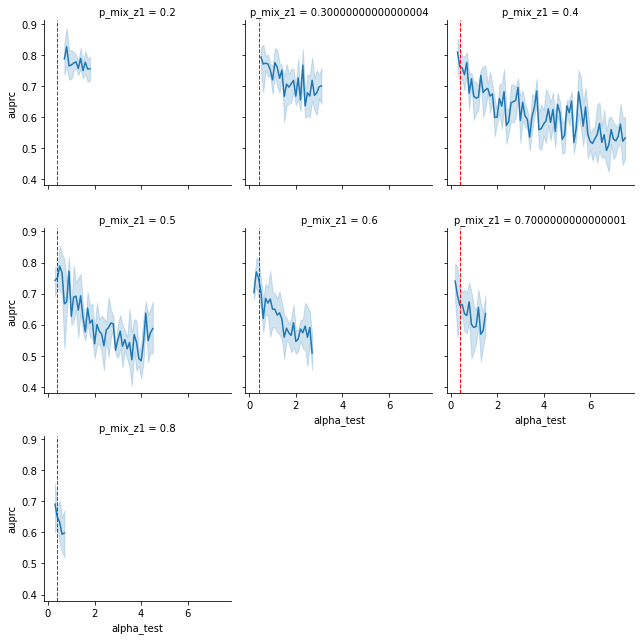

In [13]:
g = sns.FacetGrid(df, col="p_mix_z1", col_wrap=3)

g.map_dataframe(sns.lineplot, x="alpha_test", y="auprc")

g.map(plt.axvline, x=0.4, ls='--', c='red', linewidth=1)

g.set(ylabel="auprc")



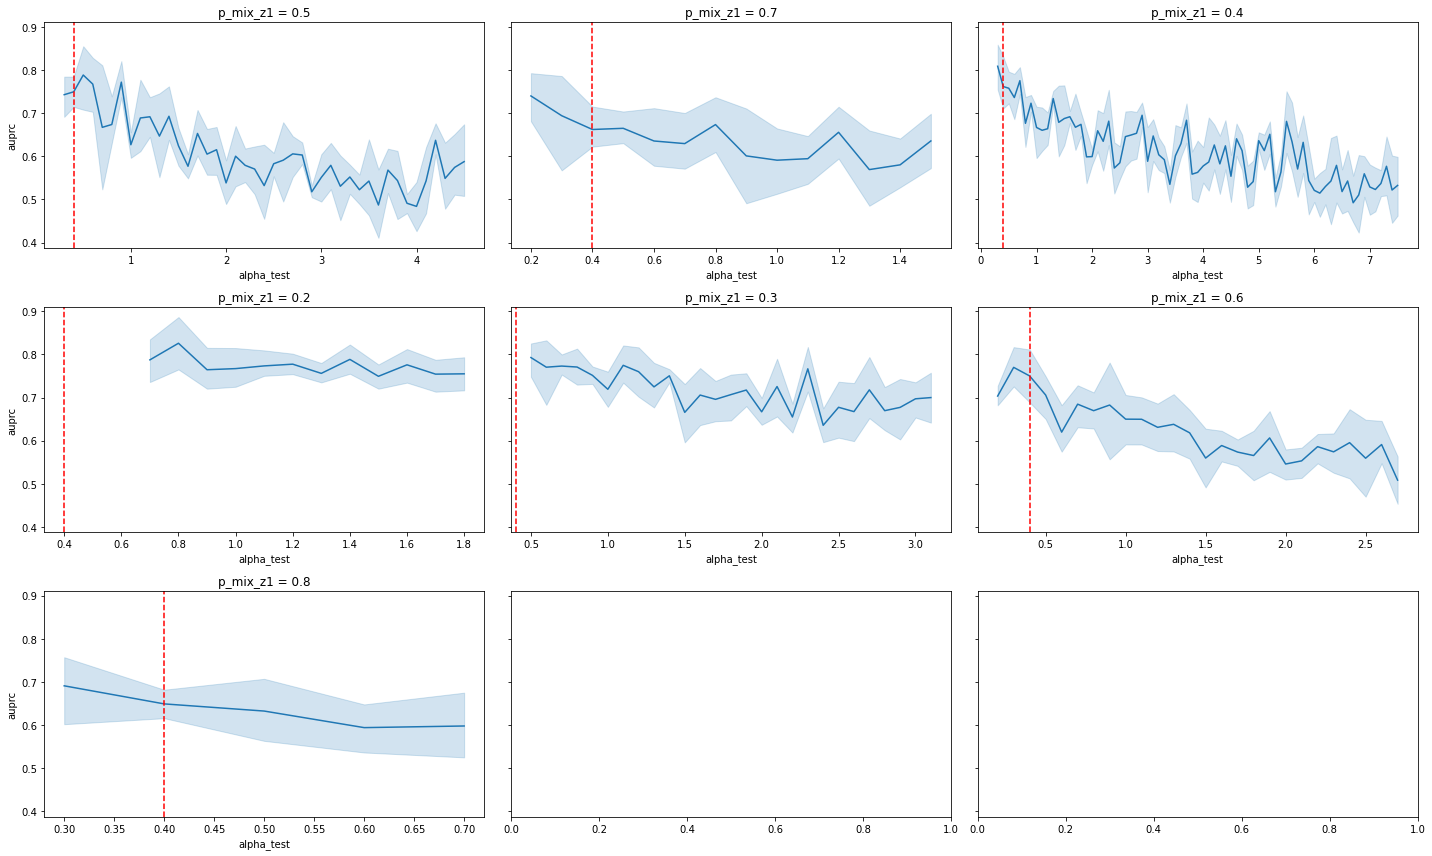

In [27]:
p_mix_z1 = df['p_mix_z1'].unique()

fig, ax = plt.subplots(math.ceil(len(p_mix_z1)/3),3, figsize=(20,12), sharey=True)
ax = ax.ravel()
for idx, k in enumerate(p_mix_z1):
    xlabel = "alpha_test"
    _df = df[df['p_mix_z1'] == k].sort_values(xlabel)
    sns.lineplot(data=_df, x=xlabel, y="auprc", ax=ax[idx])

    ax[idx].axvline(_df['alpha_train'].unique(), color="red", linestyle="--")
    ax[idx].set_title(f"p_mix_z1 = {round(k,3)}")

    plt.tight_layout()

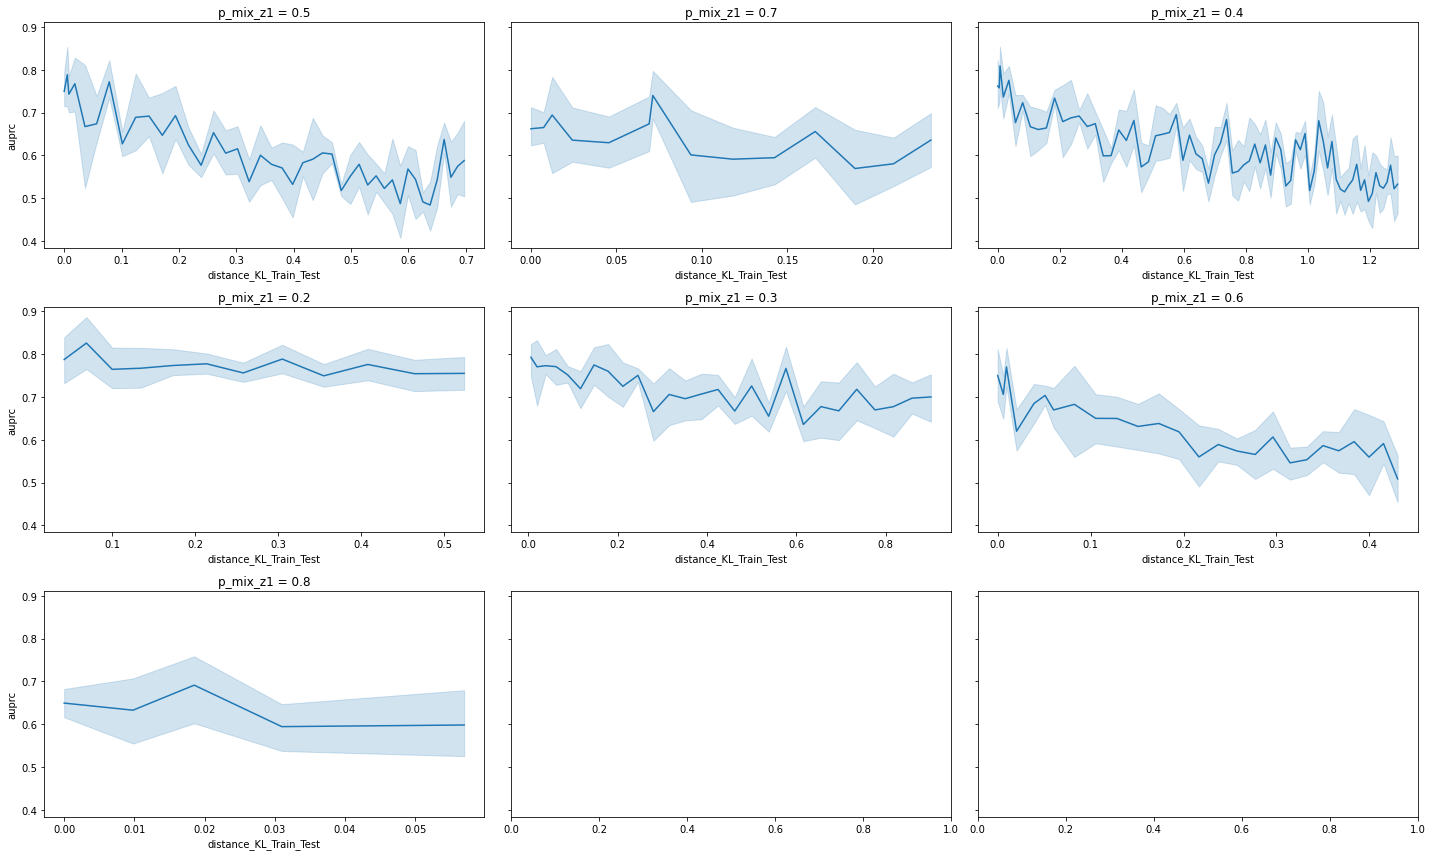

In [28]:
p_mix_z1 = df['p_mix_z1'].unique()

fig, ax = plt.subplots(math.ceil(len(p_mix_z1)/3),3, figsize=(20,12), sharey=True)
ax = ax.ravel()
for idx, k in enumerate(p_mix_z1):
    xlabel = "distance_KL_Train_Test"
    _df = df[df['p_mix_z1'] == k].sort_values(xlabel)
    sns.lineplot(data=_df, x=xlabel, y="auprc", ax=ax[idx])

    # ax[idx].axvline(_df['alpha_train'].unique(), color="red", linestyle="--")
    ax[idx].set_title(f"p_mix_z1 = {round(k,3)}")

    plt.tight_layout()

# Check Loss

In [175]:
df_ls = []

for path_i in pathlib.Path(path_results[0]).glob("setting*"):
    
    with open(pathlib.Path(path_i, "full_settings.pkl"), "br") as f:
        full_setting_i = pickle.load(f)
        
    for rand_i in path_i.glob("RandomRun_*"):
        
        
        _df = pd.read_csv(pathlib.Path(rand_i, "loss_epoch_avg.csv")).reset_index()
        _df.rename({"index":"epoch_num"}, axis=1, inplace=True)
        _df["epoch_num"] = _df["epoch_num"] + 1
        num_i = os.path.basename(rand_i).split("_")[1]
        
        y_pred = pd.read_csv(pathlib.Path(rand_i, "y_pred.csv"))
        y_prob = pd.read_csv(pathlib.Path(rand_i, "y_prob.csv"))
        y_test = pd.read_csv(pathlib.Path(rand_i, "y_test.csv"))

        _dfSetting = pd.DataFrame.from_dict(full_setting_i['mix_param_dict'], orient = 'index').T        
        _dfSetting['run'] = int(num_i)
        
        for col_i in _dfSetting.columns:
            _df[col_i] = _dfSetting[col_i].values[0]
            
        
        

        
    
        df_ls.append(_df)

In [176]:
df_loss_epoch_avg = pd.concat(df_ls).reset_index(drop=True)

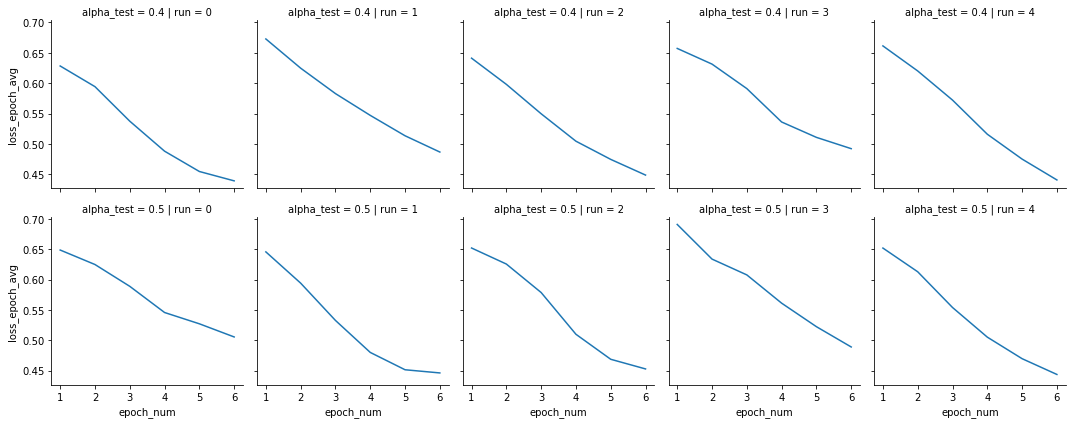

In [184]:
g = sns.FacetGrid(df_loss_epoch_avg, col="run", row="alpha_test")

g.map_dataframe(sns.lineplot, x="epoch_num", y="loss_epoch_avg")

# g.map(plt.axhline, y=df['test_loss'], ls='--', c='red', linewidth=1)

# g.set(ylabel="auprc")



In [29]:
from process_SHAC import load_process_SHAC

In [30]:
tmp = load_process_SHAC(replaceNA="all")

In [31]:
tmp

,id,Drug,Alcohol,Tobacco,SubstanceAgg,set,location,text
0,3407,True,False,False,True,train,uw,Social History: Work: Unemployed Lives with m...
1,3313,False,True,False,True,train,uw,SOCIAL HISTORY: Living situation: Comfortabl...
2,3045,True,False,True,True,train,uw,HABITS: Tobacco Use: Approximately 20 pack-ye...
3,4399,False,True,True,True,train,uw,Social History: Immigrated from [LOCATION] in ...
4,3637,False,False,True,True,train,uw,HABITS: Tobacco Use: Formerly smoked 1-2 ciga...
...,...,...,...,...,...,...,...,...
4400,2884,True,True,False,True,test,mimic,Social History: lives w/ mother in [**Name2 (N...
4401,2728,False,False,True,True,test,mimic,Social History: lives with wife (recent nursin...
4402,2854,False,True,True,True,test,mimic,"Social History: quit smoking several yrs ago, ..."
4403,2726,False,False,False,False,test,mimic,"Social History: Denies Tob, EtOH, or Illicit d..."


In [35]:
from transformers import BertModel
from transformers import AutoModelForSequenceClassification

In [38]:
BertModel.from_pretrained("mental/mental-bert-base-uncased", use_auth_token=True)

Some weights of the model checkpoint at mental/mental-bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at mental/mental-bert-base-uncased and are newly initialized: ['bert.pooler.dense.weight', 'bert

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          